In [24]:
# reset ram
%reset -f

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [26]:
%%time
file_path = '../data/cleaned/cleaned_taxi_data.csv'
chunksize = 10**6

with pd.read_csv(file_path, chunksize=chunksize) as reader:
    taxi_df = pd.concat([chunk for chunk in reader])

Wall time: 46.1 s


In [27]:
# change safety_label to category
taxi_df['safety_label'] = taxi_df['safety_label'].astype('category')

# change direction to category
taxi_df['direction'] = taxi_df['direction'].astype('category')

# change gender to category
taxi_df['gender'] = taxi_df['gender'].astype('category')

# change rating to category
taxi_df['rating'] = taxi_df['rating'].astype('category')

# change car_model to category
taxi_df['car_model'] = taxi_df['car_model'].astype('category')

# ----------------------------------------------------------------

# change driver age to int8
taxi_df['driver_age'] = taxi_df['driver_age'].astype('int8')

# change car_make_year to int16
taxi_df['car_make_year'] = taxi_df['car_make_year'].astype('int16')

# change booking_id to object
taxi_df['booking_id'] = taxi_df['booking_id'].astype('object')

In [5]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 21 columns):
 #   Column           Dtype   
---  ------           -----   
 0   booking_id       object  
 1   name             object  
 2   driver_age       int8    
 3   gender           category
 4   car_model        category
 5   car_make_year    int16   
 6   accuracy         float64 
 7   direction        category
 8   acceleration_x   float64 
 9   acceleration_y   float64 
 10  acceleration_z   float64 
 11  MA (m/s^2)       float64 
 12  gyro_x           float64 
 13  gyro_y           float64 
 14  gyro_z           float64 
 15  MAV (rad/s)      float64 
 16  second           float64 
 17  duration (mins)  float64 
 18  speed (km/h)     float64 
 19  rating           category
 20  safety_label     category
dtypes: category(5), float64(12), int16(1), int8(1), object(2)
memory usage: 854.8+ MB


In [6]:
taxi_df.head()

,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,MA (m/s^2),gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.706207,-9.270792,...,9.503762,-0.028965,-0.032652,0.015390,0.046282,2.0,0.03,0.822436,4.0,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.416705,-9.548032,...,9.830320,-0.022413,0.005049,-0.025753,0.034511,3.0,0.05,0.822436,4.0,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.346924,-9.532629,...,9.614707,0.014962,-0.050033,0.025118,0.057949,9.0,0.15,0.822436,4.0,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.600986,-9.452029,...,9.713747,0.004548,-0.011713,-0.004078,0.013210,11.0,0.18,0.822436,4.0,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.597546,-9.863403,...,10.022063,-0.000401,0.000315,-0.009830,0.009843,12.0,0.20,0.822436,4.0,0


# Normal columns
* `accuracy` feature is normal, no unusual values 
* `second` feature will need more investigation
* `speed` feature has negative values, although speed cannot be negative

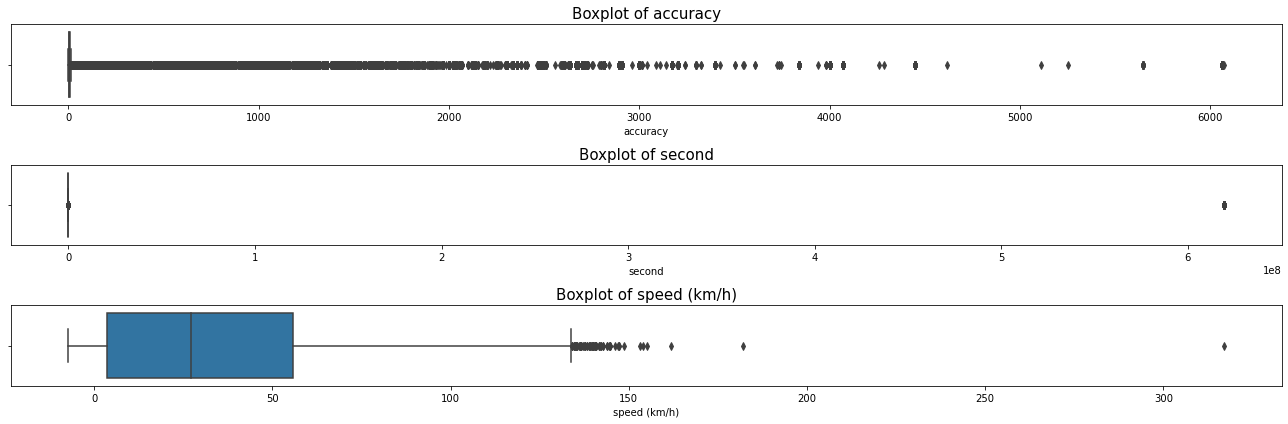

In [15]:
# boxplot of accuracy, second, speed
plt.figure(figsize=(18,6))
for i, col in enumerate(['accuracy', 'second', 'speed (km/h)']):
    plt.subplot(3,1,i+1)
    sns.boxplot(x=col, data=taxi_df)
    plt.title(f"Boxplot of {col}", fontsize=15)
    plt.tight_layout()
plt.show()

# Look at the correlation between values

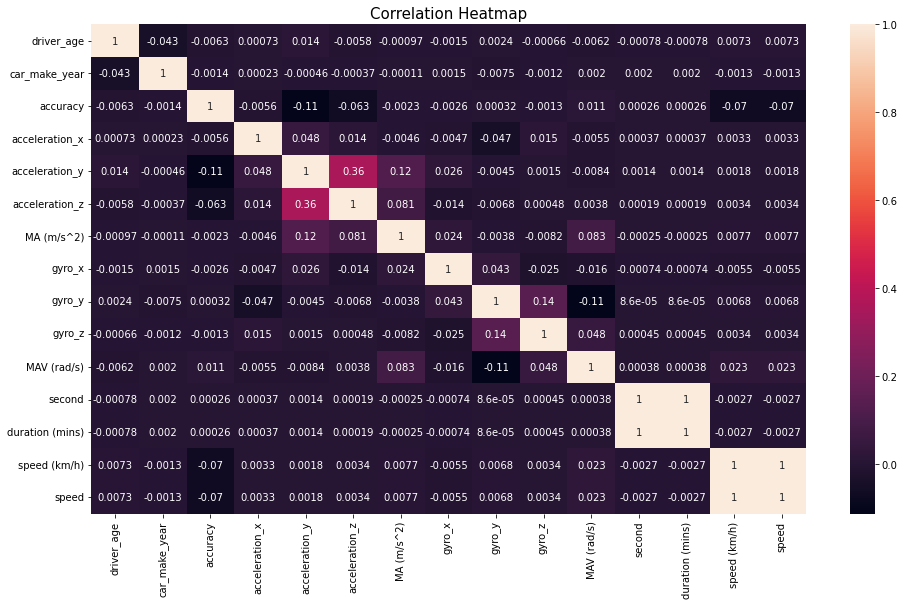

In [27]:

plt.figure(figsize=(16, 9))

sns.heatmap(taxi_df.corr(), annot=True)

plt.title('Correlation Heatmap', fontsize=15)

plt.show()

# Define outlier for accelerometer feature
I would define an outlier as a driver not exceeding 2 G Force

To calculate driver G Force I will use the following equation: magnitude of acceleration / gravity

In [37]:
taxi_df['g_force'] = taxi_df['MA (m/s^2)'] / 9.81

In [49]:
round(taxi_df['g_force'], 0).describe()

count    7.148013e+06
mean     1.004488e+00
std      1.118727e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+01
Name: g_force, dtype: float64

In [51]:
# count where g force is more than 2
outlier_g_force = taxi_df[taxi_df['g_force'] > 2]['g_force']
print(f"Percentage of dataset that has outlier g force: {(len(outlier_g_force) / len(taxi_df)) * 100}%")
print(f"Number of rows that has outlier g force: {len(outlier_g_force)}")

Percentage of dataset that has outlier g force: 0.13736911043828523%
Number of rows that has outlier g force: 10261


In [55]:
outlier_booking_id = taxi_df[taxi_df['g_force'] > 2]['booking_id']
print(f"Percentage of booking IDs with outlier G force: {outlier_booking_id.nunique() / taxi_df['booking_id'].nunique() * 100}%")
print(f"Unique booking IDs with outlier G force: {outlier_booking_id.nunique()}")

Percentage of booking IDs with outlier G force: 2.62%
Unique booking IDs with outlier G force: 524


# Define outlier for seconds
The maximum time that a driver can be on the road for a trip is 2 hours, which is from Tuas Lamp Post 1 to Changi Beach.

In [21]:
outlier_seconds_data = taxi_df[taxi_df['second'] > 7200]
print(f"Percentage of dataset that has outlier seconds {round(len(outlier_seconds_data) / len(taxi_df), 4)}%")

outlier_seconds_data = taxi_df[taxi_df['second'] > 7200]
print(f"Number of rows that has outlier seconds {len(outlier_seconds_data)}")

outlier_booking_id = taxi_df[taxi_df['second'] > 7200]['booking_id']
print(f"Percentage of unique booking id that has outlier seconds {outlier_booking_id.nunique() / taxi_df['booking_id'].nunique()}%")

Percentage of dataset that has outlier seconds 0.0001%
Number of rows that has outlier seconds 563
Percentage of unique booking id that has outlier seconds 0.0003%


# Define outlier for speed feature
It is impossible to have negative `speed` as `speed` is a scalar and only has magnitude

In [32]:
outlier_speed = taxi_df[taxi_df['speed (km/h)'] < 0]
print(f"Percentage of dataset that has outlier speed: {(len(outlier_speed) / len(taxi_df)) * 100}%")
print(f"Number of rows that has outlier speed: {len(outlier_speed)}")

Percentage of dataset that has outlier speed: 1.4689297606208371%
Number of rows that has outlier speed: 109724


In [34]:
outlier_booking_id_speed = taxi_df[taxi_df['speed (km/h)'] < 0]['booking_id']
print(f"Percentage of booking IDs with outlier speed: {outlier_booking_id_speed.nunique() / taxi_df['booking_id'].nunique() * 100}%")
print(f"Unique booking IDs with outlier speed: {outlier_booking_id_speed.nunique()}")

Percentage of booking IDs with outlier speed: 37.235%
Unique booking IDs with outlier speed: 7447


In [35]:
outlier_speed.head()

,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,MA (m/s^2),gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),rating,safety_label
273,0,Lilia,48,Male,Mercedes-Benz,2013,48.000,West,-3.170016,-9.607098,...,10.169692,-0.072483,0.051266,-0.084960,0.122883,1200.0,20.00,-3.60000,4.0,0
704,1,Arv,44,Male,Hyundai,2011,3.000,North,-0.644806,9.456484,...,9.693925,-0.000140,-0.006353,-0.003822,0.007416,700.0,11.67,-3.60000,3.5,1
815,1,Arv,44,Male,Hyundai,2011,7.709,North,0.191412,8.779959,...,9.197917,0.020176,0.010908,0.044890,0.050410,952.0,15.87,-3.60000,3.5,1
826,1,Arv,44,Male,Hyundai,2011,7.414,North,2.269167,8.553151,...,9.093537,-0.036163,-0.193976,0.012549,0.197717,994.0,16.57,-3.60000,3.5,1
1083,1005022347266,Roobbie,36,Female,Mercedes-Benz,2008,3.000,South East,-1.084976,9.612337,...,9.860504,-0.005096,0.004136,-0.002182,0.006917,500.0,8.33,-0.43684,4.0,1


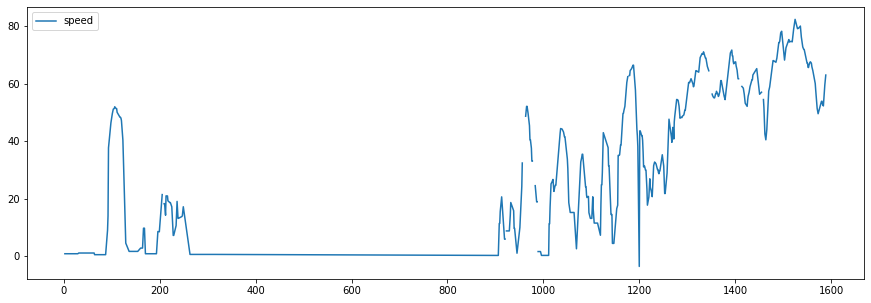

In [36]:
# matplotlib multiple lineplot
plt.figure(figsize=(15, 5))
plt.plot(taxi_df[taxi_df['booking_id'] == 0]['second'], taxi_df[taxi_df['booking_id'] == 0]['speed (km/h)'], label='speed')
plt.legend()
plt.show()